<a href="https://colab.research.google.com/github/toomij/python_ds/blob/les78/Lesson8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тема “Обучение без учителя”

## Задание 1
Импортируйте библиотеки pandas, numpy и matplotlib.
Загрузите "Boston House Prices dataset" из встроенных наборов данных библиотеки sklearn.
Создайте датафреймы X и y из этих данных.
Разбейте эти датафреймы на тренировочные (X_train, y_train) и тестовые (X_test, y_test)
с помощью функции train_test_split так, чтобы размер тестовой выборки
составлял 20% от всех данных, при этом аргумент random_state должен быть равен 42.
Масштабируйте данные с помощью StandardScaler.
Постройте модель TSNE на тренировочный данных с параметрами:
n_components=2, learning_rate=250, random_state=42.
Постройте диаграмму рассеяния на этих данных.


In [24]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 

# 2. Разделение датасета

from sklearn.model_selection import train_test_split, KFold, GridSearchCV 

# 3. Модели

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.manifold import TSNE

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2 

# 5. Для визуализации внешних картинок в ноутбуке

from IPython.display import Image

# Кластеризация
from sklearn.cluster import KMeans

In [6]:
PREPARED_DATASET_PATH = './boston_prepared.csv'


In [29]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [30]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=(15,10))
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=(15,10))

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [34]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [7]:
# Отключаем предупреждения и настраивает matplotlib


import warnings 
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [8]:
# Загружаем датасет

from sklearn.datasets import load_boston

boston = load_boston()

df = boston['data']
feature_names = boston['feature_names']
target = boston['target']

# Создаем датафрейм

X = pd.DataFrame(df, columns=feature_names)
y = pd.DataFrame(target, columns=["price"])

In [9]:
# Масштабирование данных

feature_names_for_stand = X.select_dtypes(include=['float64']).columns.tolist()
feature_names_for_stand

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [10]:
# StandardScaler() Для каждой фичи х делает: (x - mean) / std

scaler = StandardScaler()
stand_features = scaler.fit_transform(X[feature_names_for_stand])

In [11]:
stand_features

array([[-0.41978194,  0.28482986, -1.2879095 , ..., -1.45900038,
         0.44105193, -1.0755623 ],
       [-0.41733926, -0.48772236, -0.59338101, ..., -0.30309415,
         0.44105193, -0.49243937],
       [-0.41734159, -0.48772236, -0.59338101, ..., -0.30309415,
         0.39642699, -1.2087274 ],
       ...,
       [-0.41344658, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.98304761],
       [-0.40776407, -0.48772236,  0.11573841, ...,  1.17646583,
         0.4032249 , -0.86530163],
       [-0.41500016, -0.48772236,  0.11573841, ...,  1.17646583,
         0.44105193, -0.66905833]])

In [12]:
X[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501


In [13]:
# Сохранение результатов

X.to_csv(PREPARED_DATASET_PATH, index=False, encoding='utf-8', sep=';')

In [14]:
# Разбиваем на тестовые и тренировочные 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)


In [26]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min)
# StandardScaler() Для каждой фичи х делает: (x - mean) / std
# RobustScaler() Для каждой фичи х делает: (x - median) / (q75 - q25)

scaler = StandardScaler()

colnames = X.columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=colnames)

X_train_scaled.head(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.287702,-0.50032,1.033237,-0.278089,0.489252,-1.428069,1.028015,-0.802173,1.706891,1.578434,0.845343,-0.074337,1.753505
1,-0.336384,-0.50032,-0.413160,-0.278089,-0.157233,-0.680087,-0.431199,0.324349,-0.624360,-0.584648,1.204741,0.430184,-0.561474


In [31]:
# модель TSNE на тренировочный данных с параметрами: n_components=2, learning_rate=250, random_state=42
tsne = TSNE(n_components=2, learning_rate=250, random_state=17)


# tsne_representation = tsne.fit(X_train, y_train)
tsne_representaton = tsne.fit_transform(X_train_scaled)
tsne_representation

dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=30)
components_2d_tsne.head(2)


,component_1,component_2
0,28.138090,18.375324
1,-9.785578,-4.535539


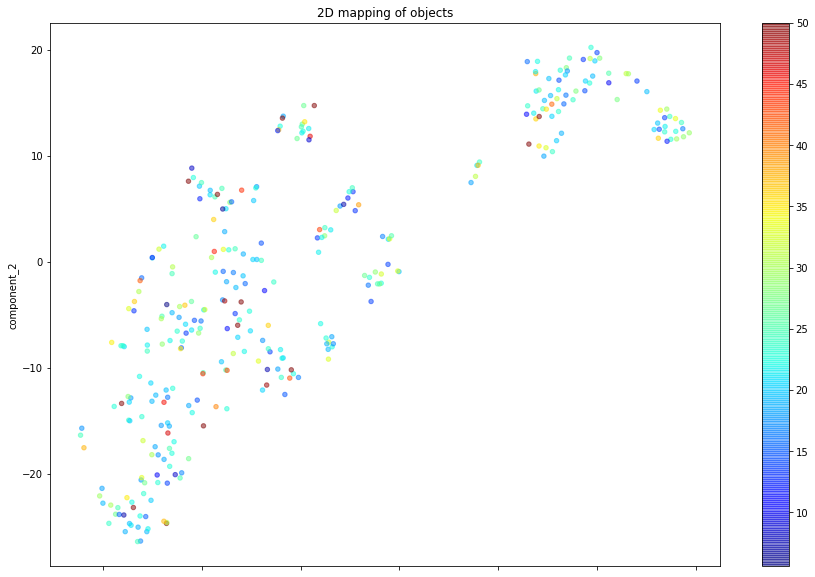

In [32]:
display_components_in_2D_space(components_2d_tsne, y_train)

## Задание 2

С помощью KMeans разбейте данные из тренировочного набора на 3 кластера,
используйте все признаки из датафрейма X_train.
Параметр max_iter должен быть равен 100, random_state сделайте равным 42.
Постройте еще раз диаграмму рассеяния на данных, полученных с помощью TSNE,
и раскрасьте точки из разных кластеров разными цветами.
Вычислите средние значения price и CRIM в разных кластерах.


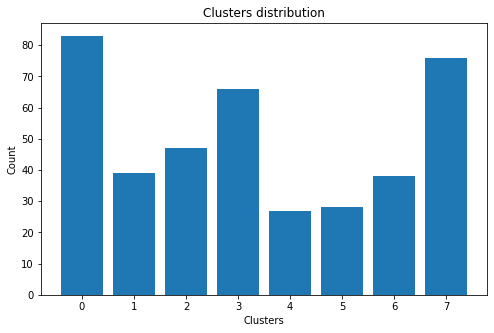

In [37]:
kmeans = KMeans(max_iter=100, random_state=42)

labels_clast = kmeans.fit_predict(X_train_scaled)
labels_clast = pd.Series(labels_clast, name='clusters_3')
labels_clast_test = kmeans.predict(X_test_scaled)
labels_clast_test = pd.Series(labels_clast_test, name='clusters_3')


unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

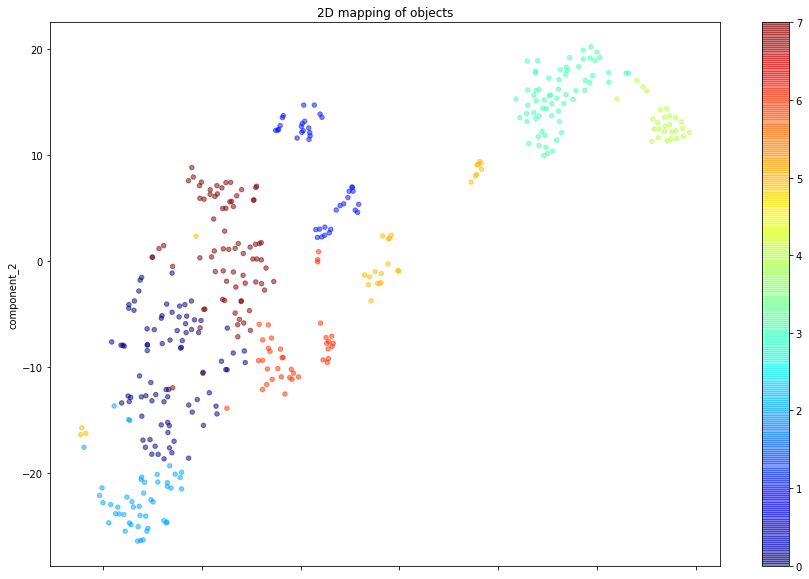

In [38]:
display_components_in_2D_space(components_2d_tsne, labels_clast)

In [45]:
labels_clast

0      3
1      7
2      0
3      4
4      7
      ..
399    7
400    0
401    2
402    4
403    7
Name: clusters_3, Length: 404, dtype: int32